# Train a PyTorch CIFAR-10 Image Classifier on Backblaze B2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cOjN8ySp6wj_i6ZlH8qulRTCV8japlHN#scrollTo=74dOjOK6CEAD)

# Train a PyTorch Image Classifier with Cloud-Hosted Data


Learn how to train an image classifier using **[PyTorch](https://pytorch.org/)** on the **CIFAR-10 dataset** hosted in **[Backblaze B2](https://www.backblaze.com/b2/cloud-storage.html)** cloud storage. This classifier learns to identify 10 different types of objects in images: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

**What you'll build:** An image classification model that can look at any photo and predict which of the 10 CIFAR-10 categories it belongs to, with a confidence score for each prediction.

## About CIFAR-10

**CIFAR-10** is a classic computer vision dataset containing 60,000 32×32 color images across 10 classes:
- **Classes:** airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **Size:** 50,000 training images, 10,000 test images
- **Use cases:** Image classification benchmarks, transfer learning baselines, computer vision education

## About PyTorch

**PyTorch** is an open-source machine learning framework that makes it easy to build and train neural networks. In this notebook, we'll use PyTorch to:
- Load and preprocess images with `torchvision`
- Train a pretrained ResNet-18 model
- Evaluate model performance
- Run inference on new images

## Dataset Hosted on Backblaze B2

This dataset is **publicly accessible** from Backblaze B2 cloud storage:
- **Location:** `s3://odh-datasets/cifar10/imagefolder/v1.0/`
- **Access:** Uses read-only credentials (provided in notebook) for listing files; individual files can be downloaded without auth
- **Format:** ImageFolder structure (`train/` and `test/` directories with class subdirectories)
- **Benefits:** Stream data directly to your training environment without manual downloads or local storage

**Note on B2 Public Buckets:** While files in public B2 buckets can be downloaded without authentication, the S3-Compatible API requires credentials to list bucket contents. We provide read-only credentials for the `odh-datasets` bucket.

## What This Notebook Does

1. **Download images on-demand** - Images are downloaded from B2 as needed during training and cached locally (first epoch slower, subsequent epochs faster)
2. **Train a ResNet-18 classifier** using PyTorch with GPU acceleration (if available) - learns to recognize 10 object categories
3. **Test on your own images** - upload any image and see the model predict which category it belongs to
4. **Save everything to B2** - model checkpoints, test images, and prediction results go to your bucket

## Setup

Install PyTorch, torchvision (for models and image transforms), and boto3 (for B2 access):

In [1]:
!pip -q install torch torchvision boto3


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


## Configuration

### Reading from Public Dataset

**Important:** While the CIFAR-10 bucket is configured as public (files can be downloaded without auth), Backblaze B2's S3-Compatible API requires authentication even for **listing** objects in public buckets.

Configure S3 client with read-only credentials to list and download images from the public dataset:

In [2]:
import boto3
from botocore.config import Config

# Public dataset configuration
B2_ENDPOINT = "https://s3.us-west-001.backblazeb2.com"
PUBLIC_BUCKET = "odh-datasets"
DATASET_PREFIX = "cifar10/imagefolder/v1.0"  # contains train/ and test/

# Read-only credentials for odh-datasets public bucket
# These credentials only have listFiles and readFiles permissions
READ_KEY_ID = "001784550ff8bb6000000000e"
READ_APP_KEY = "K001FHwrLXhwG0X3eXgfDbX4ujDYFfg"

# Client for reading public dataset (authenticated for listing)
read_client = boto3.client(
    "s3",
    endpoint_url=B2_ENDPOINT,
    aws_access_key_id=READ_KEY_ID,
    aws_secret_access_key=READ_APP_KEY,
    config=Config(signature_version="s3v4")
)

### Your B2 Bucket for Outputs

**Get your B2 credentials:**
1. Log into [Backblaze B2](https://www.backblaze.com/b2/cloud-storage.html)
2. Create a bucket (or use an existing one)
3. Create an Application Key with write access to your bucket
4. Copy the Bucket Name, Key ID, and Application Key

**Enter your credentials below** (they'll be stored for this session only):

In [ ]:
import boto3
from botocore.config import Config
from getpass import getpass

# --- Connect to Your Backblaze B2 Bucket ---

print("Enter your Backblaze B2 connection details:")
YOUR_BUCKET = input("Bucket name: ").strip()
B2_REGION = input("Region (e.g. us-west-004, us-east-005, eu-central-003, ap-southeast-002): ").strip()
YOUR_KEY_ID = input("Key ID: ").strip()
YOUR_APP_KEY = getpass("Application Key (hidden): ").strip()

# Validate inputs
if not all([YOUR_BUCKET, B2_REGION, YOUR_KEY_ID, YOUR_APP_KEY]):
    raise ValueError("All fields are required. Please run this cell again.")

# Build endpoint dynamically
B2_ENDPOINT = f"https://s3.{B2_REGION}.backblazeb2.com"

# Create S3-compatible client for Backblaze B2
write_client = boto3.client(
    "s3",
    endpoint_url=B2_ENDPOINT,
    region_name=B2_REGION,
    aws_access_key_id=YOUR_KEY_ID,
    aws_secret_access_key=YOUR_APP_KEY,
    config=Config(
        signature_version="s3v4",
        retries={'max_attempts': 3, 'mode': 'standard'},
        user_agent_extra="b2-notebook-pytorch"
    )
)

# Verify access by listing first few objects
try:
    resp = write_client.list_objects_v2(Bucket=YOUR_BUCKET, MaxKeys=5)
    if "Contents" in resp:
        print(f"\n✓ Connected to Backblaze B2 bucket: {YOUR_BUCKET} in region {B2_REGION}")
        print("Sample objects:")
        for obj in resp["Contents"]:
            print(f"  - {obj['Key']}")
    else:
        print(f"\n✓ Connected to bucket {YOUR_BUCKET}, but it appears empty.")
except Exception as e:
    print(f"\n⚠️ Connection test failed: {e}")


## List Dataset Files from B2

Get the paths of all 60,000 images in the dataset (50K train + 10K test) - we'll download them later on-demand:

In [13]:
def list_images(client, bucket, prefix):
    """List all image files under a prefix."""
    keys, token = [], None
    while True:
        kwargs = {"Bucket": bucket, "Prefix": prefix, "MaxKeys": 1000}
        if token:
            kwargs["ContinuationToken"] = token

        resp = client.list_objects_v2(**kwargs)
        for obj in resp.get("Contents", []):
            key = obj["Key"]
            if key.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                keys.append(key)

        if resp.get("IsTruncated"):
            token = resp["NextContinuationToken"]
        else:
            break
    return keys

train_keys = list_images(read_client, PUBLIC_BUCKET, f"{DATASET_PREFIX}/train/")
test_keys = list_images(read_client, PUBLIC_BUCKET, f"{DATASET_PREFIX}/test/")

print(f"Found {len(train_keys):,} training images")
print(f"Found {len(test_keys):,} test images")

Found 50,000 training images
Found 10,000 test images


## PyTorch Dataset with Optimized Downloads

Create a custom Dataset with production-ready optimizations:
- **Per-worker S3 clients** - Each DataLoader worker gets its own connection for parallel downloads
- **Atomic caching** - Prevents corrupted files from partial downloads
- **Automatic retries** - Handles network errors gracefully
- **Prefetching** - Overlaps data loading with GPU computation for faster training

In [14]:
import hashlib
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import time

CACHE_DIR = Path("/content/b2_cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

def extract_label(key, split):
    """Extract class label from key path: .../<split>/<class>/image.png"""
    parts = key.split("/")
    split_idx = parts.index(split)
    return parts[split_idx + 1]

class B2ImageDataset(Dataset):
    def __init__(self, keys, split, s3_client, bucket, endpoint, key_id, app_key,
                 transform=None, class_to_idx=None):
        self.keys = keys
        self.split = split
        self.bucket = bucket
        self.endpoint = endpoint
        self.key_id = key_id
        self.app_key = app_key
        self.transform = transform

        # Per-worker S3 client (created lazily)
        self._s3_client = None
        self._worker_id = None

        # Build class mapping
        classes = sorted({extract_label(k, split) for k in keys})
        self.class_to_idx = class_to_idx or {c: i for i, c in enumerate(classes)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}

    def _get_s3_client(self):
        """Get or create a per-worker S3 client for parallel downloads."""
        import torch.utils.data
        worker_info = torch.utils.data.get_worker_info()
        worker_id = worker_info.id if worker_info is not None else None

        # Create new client if worker changed or doesn't exist
        if self._s3_client is None or self._worker_id != worker_id:
            self._worker_id = worker_id
            self._s3_client = boto3.client(
                "s3",
                endpoint_url=self.endpoint,
                aws_access_key_id=self.key_id,
                aws_secret_access_key=self.app_key,
                config=Config(signature_version="s3v4")
            )
        return self._s3_client

    def __len__(self):
        return len(self.keys)

    def _get_cached_path(self, key):
        """Get local cache path for a B2 key."""
        h = hashlib.sha1(key.encode()).hexdigest()[:16]
        filename = key.split("/")[-1]
        return CACHE_DIR / f"{h}_{filename}"

    def _download_with_retry(self, key, max_retries=3):
        """Download file from B2 with automatic retries and atomic caching."""
        cache_path = self._get_cached_path(key)

        # Return if already cached
        if cache_path.exists():
            return cache_path

        # Use temporary file for atomic writes (prevents corruption)
        temp_path = cache_path.with_suffix(cache_path.suffix + ".tmp")

        # Try downloading with retries
        s3 = self._get_s3_client()
        for attempt in range(max_retries):
            try:
                obj = s3.get_object(Bucket=self.bucket, Key=key)
                temp_path.write_bytes(obj["Body"].read())

                # Atomic rename (only visible when complete)
                temp_path.rename(cache_path)
                return cache_path

            except Exception as e:
                if attempt == max_retries - 1:
                    raise RuntimeError(f"Failed to download {key} after {max_retries} attempts: {e}")
                time.sleep(0.1 * (2 ** attempt))  # Exponential backoff

        return cache_path

    def __getitem__(self, idx):
        key = self.keys[idx]
        label = extract_label(key, self.split)
        label_idx = self.class_to_idx[label]

        # Download with retry logic and atomic caching
        image_path = self._download_with_retry(key)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label_idx

## Create Optimized DataLoaders

Configure DataLoaders with prefetching and multiple workers for parallel I/O to overlap downloads with GPU computation:

In [15]:
import torch
from torch.utils.data import DataLoader

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Create datasets with credentials for per-worker clients
train_ds = B2ImageDataset(
    train_keys, "train", read_client, PUBLIC_BUCKET,
    B2_ENDPOINT, READ_KEY_ID, READ_APP_KEY,
    transform=train_transform
)
test_ds = B2ImageDataset(
    test_keys, "test", read_client, PUBLIC_BUCKET,
    B2_ENDPOINT, READ_KEY_ID, READ_APP_KEY,
    transform=test_transform, class_to_idx=train_ds.class_to_idx
)

# Optimized DataLoader settings
BATCH_SIZE = 128
NUM_WORKERS = 4  # Parallel downloads (adjust based on CPU cores)
PREFETCH_FACTOR = 2  # Batches to prefetch per worker

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    pin_memory=True,  # Faster CPU->GPU transfer
    persistent_workers=True  # Reuse workers across epochs
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    pin_memory=True,
    persistent_workers=True
)

# Show class names
num_classes = len(train_ds.class_to_idx)
class_names = [train_ds.idx_to_class[i] for i in range(num_classes)]
print(f"\nClasses ({num_classes}): {class_names}")
print(f"\nDataLoader config: {NUM_WORKERS} workers, prefetch {PREFETCH_FACTOR} batches per worker")
print(f"Total prefetch capacity: {NUM_WORKERS * PREFETCH_FACTOR * BATCH_SIZE} images")


Classes (10): ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

DataLoader config: 4 workers, prefetch 2 batches per worker
Total prefetch capacity: 1024 images


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Define Model

Load a pretrained ResNet-18 model and adapt it for 10-class classification (uses GPU if available):

In [16]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained ResNet-18 and adapt for CIFAR-10
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

Using device: cuda


## Training Functions

Define functions to train for one epoch and evaluate the model on test data:

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

## Train the Model

Run training for 3 epochs - images download from B2 as needed on first epoch, then use cached versions:

In [18]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

    print(f"Epoch {epoch}/{EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.3f}")
    print(f"  Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.3f}")

Epoch 1/3:
  Train - Loss: 1.0478, Acc: 0.641
  Test  - Loss: 0.8757, Acc: 0.709
Epoch 2/3:
  Train - Loss: 0.7421, Acc: 0.747
  Test  - Loss: 0.7258, Acc: 0.754
Epoch 3/3:
  Train - Loss: 0.6499, Acc: 0.778
  Test  - Loss: 0.8734, Acc: 0.728


## Save Checkpoint to Your B2 Bucket

Serialize the trained model state and upload it to your B2 bucket for later use:

In [24]:
import io
from datetime import datetime

# Create checkpoint
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "class_names": class_names,
    "epoch": EPOCHS,
    "test_accuracy": test_acc,
}

# Serialize to bytes
buffer = io.BytesIO()
torch.save(checkpoint, buffer)
buffer.seek(0)

# Upload to your bucket
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_key = f"cifar10-training/checkpoints/resnet18_{timestamp}.pt"

write_client.upload_fileobj(buffer, YOUR_BUCKET, checkpoint_key)
print(f"✓ Checkpoint saved to: s3://{YOUR_BUCKET}/{checkpoint_key}")
print(f"  Test accuracy: {test_acc:.1%}")

✓ Checkpoint saved to: s3://ml-training-test/cifar10-training/checkpoints/resnet18_20251111_183101.pt
  Test accuracy: 72.8%


## Test the Classifier on Your Own Images

Upload an image from your computer to test the trained model:

In [25]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Upload image from your computer
print("Upload an image to classify:")
print("Expected classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck\n")
uploaded = files.upload()

# Get the uploaded filename
test_image_filename = list(uploaded.keys())[0]
print(f"\nProcessing: {test_image_filename}")

Upload an image to classify:
Expected classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck



Saving draw-an-airplane.jpg to draw-an-airplane.jpg

Processing: draw-an-airplane.jpg


## Run Inference and Visualize Results

Process the uploaded image through the model and display predictions with confidence scores:


🎯 Prediction: airplane
   Confidence: 98.5%

Top 3 predictions:
  1. airplane     - 98.5%
  2. bird         - 1.2%
  3. frog         - 0.1%


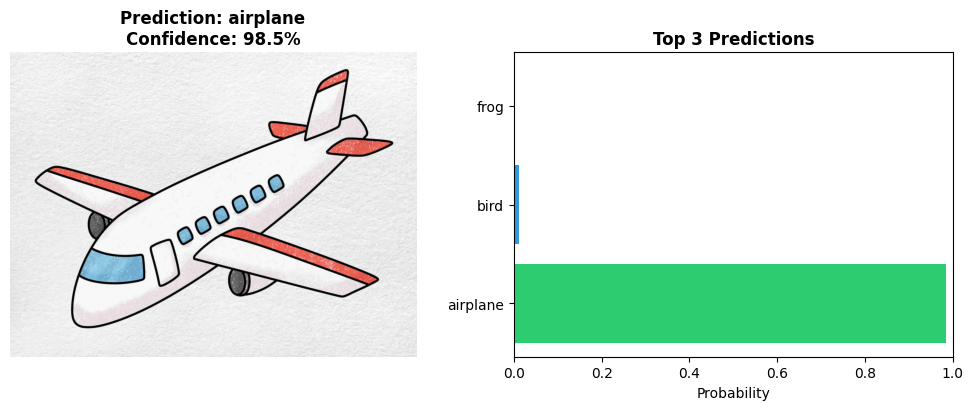

In [26]:
# Run inference
model.eval()

# Load and preprocess image
test_image = Image.open(test_image_filename).convert("RGB")
original_size = test_image.size

# Apply same transforms as test set
input_tensor = test_transform(test_image).unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get top prediction
top_prob, top_idx = probabilities.max(0)
predicted_class = class_names[top_idx.item()]

# Get top 3 predictions
top3_probs, top3_indices = probabilities.topk(3)
top3_predictions = [
    {"class": class_names[idx.item()], "probability": prob.item()}
    for prob, idx in zip(top3_probs, top3_indices)
]

# Display results
print(f"\n🎯 Prediction: {predicted_class}")
print(f"   Confidence: {top_prob.item():.1%}\n")
print("Top 3 predictions:")
for i, pred in enumerate(top3_predictions, 1):
    print(f"  {i}. {pred['class']:12s} - {pred['probability']:.1%}")

# Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title(f"Prediction: {predicted_class}\nConfidence: {top_prob.item():.1%}", fontsize=12, fontweight='bold')
plt.axis("off")

plt.subplot(1, 2, 2)
classes_display = [p['class'] for p in top3_predictions]
probs_display = [p['probability'] for p in top3_predictions]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(3)]
plt.barh(classes_display, probs_display, color=colors)
plt.xlabel("Probability", fontsize=10)
plt.title("Top 3 Predictions", fontsize=12, fontweight='bold')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

## Save Test Results to Your B2 Bucket

Upload both the test image and prediction results (as JSON) to your B2 bucket for record keeping:

In [ ]:
import json

test_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
test_prefix = f"cifar10-training/test_results/{test_timestamp}"

# 1. Upload the test image
image_ext = test_image_filename.split('.')[-1]
image_key = f"{test_prefix}/input.{image_ext}"

with open(test_image_filename, "rb") as f:
    write_client.upload_fileobj(f, YOUR_BUCKET, image_key)

print(f"✓ Test image saved to: s3://{YOUR_BUCKET}/{image_key}")

# 2. Save prediction results as JSON
results = {
    "filename": test_image_filename,
    "timestamp": test_timestamp,
    "original_size": original_size,
    "predicted_class": predicted_class,
    "confidence": float(top_prob.item()),
    "top3_predictions": top3_predictions,
    "model_checkpoint": checkpoint_key,
    "dataset": "CIFAR-10",
    "dataset_source": f"s3://{PUBLIC_BUCKET}/{DATASET_PREFIX}"
}

results_key = f"{test_prefix}/predictions.json"
results_json = json.dumps(results, indent=2)

write_client.put_object(
    Bucket=YOUR_BUCKET,
    Key=results_key,
    Body=results_json.encode('utf-8'),
    ContentType='application/json'
)

print(f"✓ Predictions saved to: s3://{YOUR_BUCKET}/{results_key}")
print(f"\n📁 All test outputs in: s3://{YOUR_BUCKET}/{test_prefix}/")

## Summary

### What We Accomplished

✓ **Streamed CIFAR-10 from public B2 bucket** - No dataset download required  
✓ **Trained ResNet-18 classifier** - With local caching for efficiency  
✓ **Tested on custom images** - Upload any image and get predictions  
✓ **Saved all outputs to your B2 bucket** - Checkpoints and test results

### Your B2 Bucket Structure

```
your-bucket-name/
├── cifar10-training/
│   ├── checkpoints/
│   │   └── resnet18_<timestamp>.pt
│   └── test_results/
│       └── <timestamp>/
│           ├── input.<ext>
│           └── predictions.json
```

### Key Benefits of B2 for ML Training

- **No egress fees** - Download training data without unexpected costs
- **S3-compatible** - Works with existing boto3/AWS SDK code
- **Scalable storage** - Store checkpoints, results, and datasets in one place

### Next Steps

- Load your saved checkpoint and continue training
- Fine-tune on your own dataset in B2
- Explore other public datasets at opendatahub.ai
- Deploy your model for production inference